In [ ]:
# Arima forecasts

In [ ]:
#tags
# time series, arima, forecast, acf, pacf

In [ ]:
# References
[statsmodels - Time Series libraries](https://www.statsmodels.org/stable/tsa.html)
[Arima forecasting](https://www.justintodata.com/arima-models-in-python-time-series-prediction/)

In [ ]:
# TO ADD
explaining acf, pacf plots

In [33]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline
sns.set()

# settings
import warnings
warnings.filterwarnings('ignore')
#print all rows of a df in ipython shell 
pd.set_option('display.max_rows', None)
#print all columns of a df in ipython shell 
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option("display.precision", 6)

# optional
#pd.set_option('display.max_columns',100)
sns.set_style('darkgrid')


In [2]:
# Load data

# path = 'e:\PycharmProjects\TimeSeries'
path = os.path.abspath(os.getcwd())

# load apple, google data 
webtraffic_file = 'website_data.csv'
file_path = os.path.join(path, 'data', webtraffic_file)

df = pd.read_csv(file_path).dropna()

In [3]:
# Quick check

df.sample(5)
df.head(5)
df.tail(5)

,traffic
388,4667
389,4701
390,4721
391,4757
392,4865


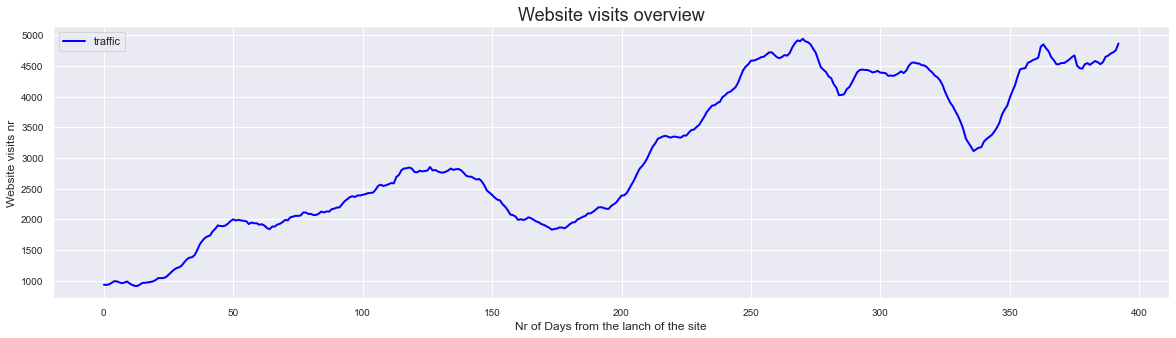

In [6]:
# Basic visualisation

# Plot the time series in your DataFrame
ax = df.plot(color='blue', figsize=(20, 5), linewidth=2, fontsize=10)

# Specify the x-axis label in your plot
ax.set_xlabel('Nr of Days from the lanch of the site')

# Specify the y-axis label in your plot
ax.set_ylabel('Website visits nr')

# Specify the title in your plot
ax.set_title('Website visits overview', fontsize=18)


# Show plot
plt.show()


<AxesSubplot:>

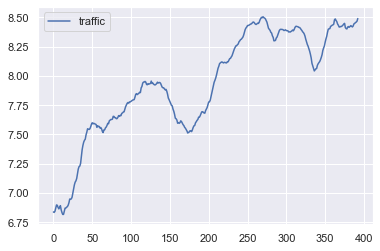

In [13]:
# There is a variance in data logarithm can be applied to solve it.

import numpy as np
df = np.log(df) # don't forget to transform the data back when making real predictions

df.plot()
# the plot is less variant across time compared to the original one.

In [ ]:
# Apply also variance - heterokedasticity tests (later in the notebook)

In [14]:
# Split the training and test set
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

In [ ]:
# Check for stationarity

In [ ]:
# Method 1: look at the plot

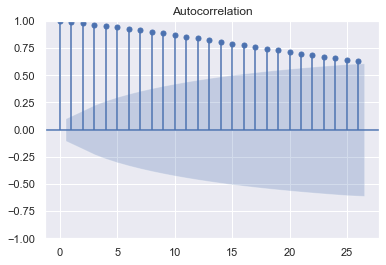

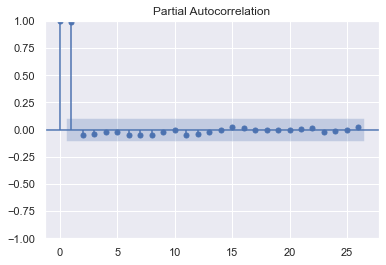

In [15]:
# Method 2: ACF, PACF plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [16]:
# Method 3 - adf test

#The ADF (Augmented Dickey-Fuller) test tests for the null hypothesis that there is a unit root (non-stationary).

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.2412611608288312


In [ ]:
# p-value > 0.05 - the time series is not stationary

<AxesSubplot:>

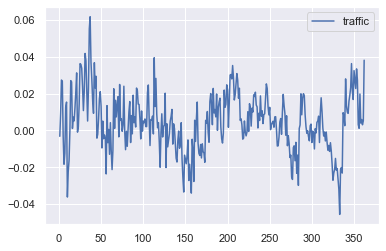

In [17]:
# Transform to stationary: differencing

df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

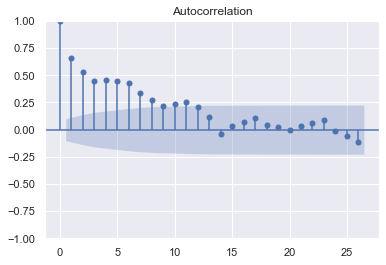

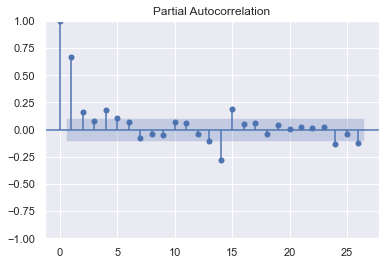

In [18]:
# Check one again the stationarity - acf, pacf

acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

#Compared to the original series, the ACF plot (left) drops in value more quickly.
#While the PACF plot (right) also shows a less strong spike at lag 1. These are signs of the series being more stationary.

In [20]:
# Check one again the stationarity - adfuller

adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

# p-value < 0.05 is more stationary 

p-value: 0.02205946123912647


In [ ]:
# Step 2: Determine ARIMA models parameters p, q from the acf and pacf plots

Here is a rule of thumb for selecting the values of p and q:

    If the PACF plot has a significant spike at lag p, but not beyond; the ACF plot decays more gradually. This may suggest an ARIMA(p, d, 0) model
    If the ACF plot has a significant spike at lag q, but not beyond; the PACF plot decays more gradually. This may suggest an ARIMA(0, d, q) model

This is because the PACF measures the balance variance of the lags; it helps tell us whether we should include such lag within the auto-regressive (AR) models. While the ACF measures the correlations with the lags, it helps judge the moving average (MA) models. Most of the time, we should focus on either the AR or the MA models, not mixed.

For our differenced series, the PACF has a large spike at lag 1, and still shows more minor but significant lags at 2, 4, and 5. In contrast, the ACF shows a more gradual decay. So we can try for ARIMA models with the p parameter being 2, 3, 4, or even 5. Let’s try 2 since we usually prefer a simpler model. So we’ll fit an ARIMA(2, 1, 0) model.

As you can see, it can be hard and highly subjective to select appropriate values for the parameters of ARIMA models. You may try multiple models to find the best one for your need.

In [21]:
#Step 3: Fit the ARIMA model

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1096.369
Date:                Sun, 10 Sep 2023   AIC                          -2186.737
Time:                        16:46:12   BIC                          -2175.063
Sample:                             0   HQIC                         -2182.096
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5806      0.050     11.662      0.000       0.483       0.678
ar.L2          0.1687      0.058      2.903      0.004       0.055       0.283
sigma2         0.0001   8.23e-06     16.612      0.0

In [ ]:
# Step 4: Make time series predictions

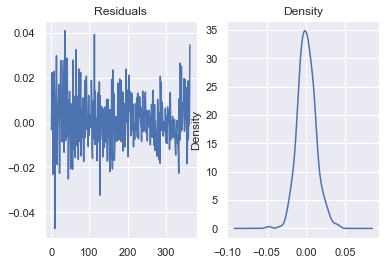

In [23]:
# Before prediction check the model whether the  model has captured adequate information from the data. 

# Method 1. by looking at the residuals. If the model is good, its residuals should look like white noise.

import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

#The residuals look random in general, and their density looks normally distributed with a mean of around 0.

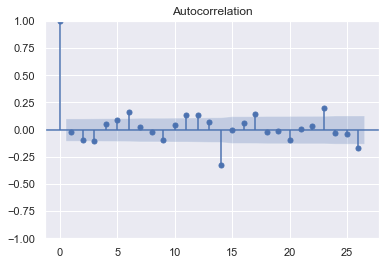

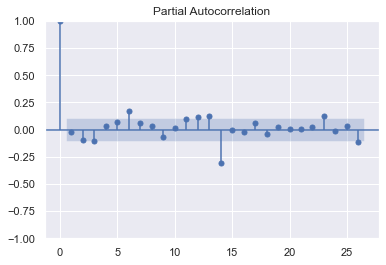

In [24]:
# Method 2 - ACF and PACF plots of the residuals
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

# The lower lags barely show any significant ‘spikes’.
# These show that the residuals are close to white noise. We are ready to forecast with this model ARIMA(2, 1, 0).

<AxesSubplot:>

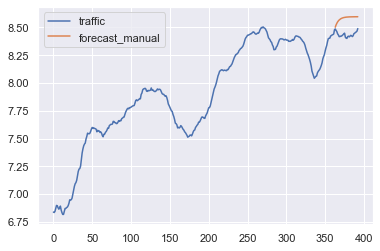

In [25]:
# Calculate the predictions

forecast_test = model_fit.forecast(len(df_test))
df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

# You can see that the forecast follows the previous momentum and shows an upward trend. 
# While in reality, the traffic fell at first before heading back up.

In [ ]:
# Auto-fit the ARIMA model 

In [27]:
# Method 1 : pmdarima package

import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [29]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1107.360
Date:                Sun, 10 Sep 2023   AIC                          -2200.719
Time:                        17:00:13   BIC                          -2173.478
Sample:                             0   HQIC                         -2189.890
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.510      0.131      -0.000       0.002
ar.L1          0.5209      0.052      9.973      0.000       0.419       0.623
ar.L2          0.0937      0.065      1.439      0.150      -0.034       0.221
ar.L3         -0.0362      0.064     -0.563      0.573      -0.162       0.090
ar.L4          0.1281      0.053      2.417      0.016       0.024       0.232
ar.L5          0.1018      0.049      2.063      0.039       0.005       0.199
sigma2         0.0001   8.59e-06     14.964      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.86
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Step 5: Evaluate model predictions

<AxesSubplot:>

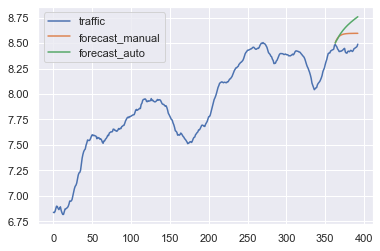

In [30]:
# Compare arima(2,1,0) and arima(5,1,0) predictions

forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

# First, if we plot both models’ predictions together, you can see that the manually fitted model of ARIMA(2, 1, 0) is closer to the actual test set.

In [31]:
# MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and RMSE (Root Mean Squared Error) for the manual model

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.14514968388076604
mape - manual: 0.017216198515850756
rmse - manual: 0.15051403899106064


In [32]:
# MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and RMSE (Root Mean Squared Error) for the automatic model

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.21685081928833536
mape - auto: 0.025713635204390038
rmse - auto: 0.23112824939045293


In [ ]:
# Method2. Autofit the arima parameters using a custom optimiser function

In [49]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [50]:
from tqdm import tqdm_notebook
from itertools import product

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df_train['traffic'])

result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(6, 1, 4)",-2221.9
1,"(4, 1, 5)",-2216.1
2,"(7, 1, 3)",-2207.9
3,"(5, 1, 4)",-2207.7
4,"(6, 1, 7)",-2207.1
5,"(7, 1, 7)",-2206.0
6,"(6, 1, 3)",-2206.0
7,"(4, 1, 7)",-2204.2
8,"(5, 1, 7)",-2204.2
9,"(7, 1, 0)",-2200.5


In [43]:
# Fit the model with arima(6,1,4)

from statsmodels.tsa.arima.model import ARIMA
model_opt = ARIMA(df_train, order=(2,1,1))
model_fit_opt = model_opt.fit()
print(model_fit_opt.summary())


                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1102.860
Date:                Sun, 10 Sep 2023   AIC                          -2197.719
Time:                        17:59:13   BIC                          -2182.153
Sample:                             0   HQIC                         -2191.531
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2255      0.122     10.007      0.000       0.985       1.466
ar.L2         -0.2737      0.105     -2.616      0.009      -0.479      -0.069
ma.L1         -0.7028      0.108     -6.483      0.0

<AxesSubplot:>

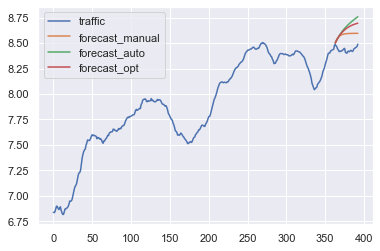

In [44]:
# Compare arima(2,1,0) and arima(5,1,0), arima(6,1,4) predictions

forecast_test_opt = model_fit_opt.forecast(len(df_test))
df['forecast_opt'] = [None]*len(df_train) + list(forecast_test_opt)


df.plot()

# CHat GPT

In [ ]:
# Q: what does it mean that this time series’ variance doesn’t look constant throughout time. Give me example in python

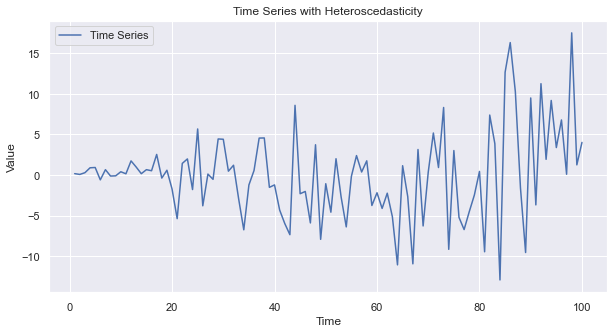

In [7]:
# Generate a time series with non-constant variance

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
time = np.arange(1, 101)  # Time steps from 1 to 100
data = np.random.randn(100) * (0.1 * time)  # Variance increases with time

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(time, data, label='Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Heteroscedasticity')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In this example, we generate a synthetic time series where the variance increases linearly with time. You can observe the increasing spread of data points as time progresses, indicating heteroscedasticity. To formally test for heteroscedasticity, you can use statistical tests like the White test or Breusch-Pagan test, which are available in libraries like statsmodels in Python. These tests can help quantify the presence of heteroscedasticity in your time series data.

In [12]:
# Check for variance - heterokedasticity 

# Apply White, breuschpagan, goldfeldquandt test
# If the p-value is below a chosen significance level (e.g., 0.05), conclude that there is evidence of heteroscedasticity in the time series data.
# because the null hipothesis is that there is no variance in data. Variance is oscilling the data over time. 
# The test works on the residuals of a linear model. 

import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, het_goldfeldquandt

# Generate a time series with non-constant variance
np.random.seed(0)
time = np.arange(1, 101)  # Time steps from 1 to 100
data = np.random.randn(100) * (0.1 * time)  # Variance increases with time

# Fit a regression model to the data
X = sm.add_constant(time)
model = sm.OLS(data, X).fit()

# White test for heteroscedasticity
white_test_statistic, white_p_value, _, _ = het_white(model.resid, X)
print(f'White Test Statistic: {white_test_statistic}')
print(f'White Test p-value: {white_p_value}')

# Breusch-Pagan test for heteroscedasticity
bp_test_statistic, bp_p_value, _, _ = het_breuschpagan(model.resid, X)
print(f'Breusch-Pagan Test Statistic: {bp_test_statistic}')
print(f'Breusch-Pagan Test p-value: {bp_p_value}')

# Goldfeld-Quandt test for heteroscedasticity
gq_test_statistic, gq_p_value, split_idx = het_goldfeldquandt(model.resid, X)
print(f'Goldfeld-Quandt Test Statistic: {gq_test_statistic}')
print(f'Goldfeld-Quandt Test p-value: {gq_p_value}')
print(f'Split Index: {split_idx}')

White Test Statistic: 21.098741194363445
White Test p-value: 2.620997230776671e-05
Breusch-Pagan Test Statistic: 20.265400254992283
Breusch-Pagan Test p-value: 6.740865834777723e-06
Goldfeld-Quandt Test Statistic: 3.8812444148362752
Goldfeld-Quandt Test p-value: 3.215585496862834e-06
Split Index: increasing


In [ ]:
# Miscellous

In [99]:
import pandas as pd

# Sample DataFrame
data = {
    'Name': ['John', 'Alice', 'Bob', 'Jane'],
    'Age': [25, 30, 35, 40],
    'City': ['New York', 'London', 'Paris', 'Tokyo']
}

df = pd.DataFrame(data)

# Variable for the query condition
age_threshold = 30

# Using the variable in the query
result = df.query(f'Age > {age_threshold}')

print(result)

   Name  Age   City
2   Bob   35  Paris
3  Jane   40  Tokyo
